In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
level_of_risk = pd.read_csv("level-of-risk.csv")
level_of_risk.head()

,operationId,controlId,level of risk,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [3]:
controls = pd.read_csv("controls.csv")
controls.head()

,controlId,title,type
0,1.0,Wheel Management,Decontamination
1,2.0,Wheel Management,Decontamination
2,3.0,Wheel Management,Decontamination
3,4.0,Wheel Management,Decontamination
4,5.0,Wheel Management,Decontamination


In [4]:
n_level_of_risk = len(level_of_risk)
n_controls = level_of_risk['controlId'].nunique()
n_operations = level_of_risk['operationId'].nunique()

print(f"Number of risk leveling: {n_level_of_risk}")
print(f"Number of unique controlId's: {n_controls}")
print(f"Number of unique operations: {n_operations}")
print(f"Average number of risk leveling per operation: {round(n_level_of_risk/n_operations, 2)}")
print(f"Average number of risk leveling per control: {round(n_level_of_risk/n_controls, 2)}")

Number of risk leveling: 100836
Number of unique controlId's: 9724
Number of unique operations: 610
Average number of risk leveling per operation: 165.3
Average number of risk leveling per control: 10.37


In [5]:
operation_freq = level_of_risk[['operationId', 'controlId']].groupby('operationId').count().reset_index()
operation_freq.columns = ['operationId', 'n_level_of_risk']
operation_freq.head()

,operationId,n_level_of_risk
0,1,232
1,2,29
2,3,39
3,4,216
4,5,44


In [6]:
print(f"Mean number of risk leveling for a given operation: {operation_freq['n_level_of_risk'].mean():.2f}.")

Mean number of risk leveling for a given operation: 165.30.


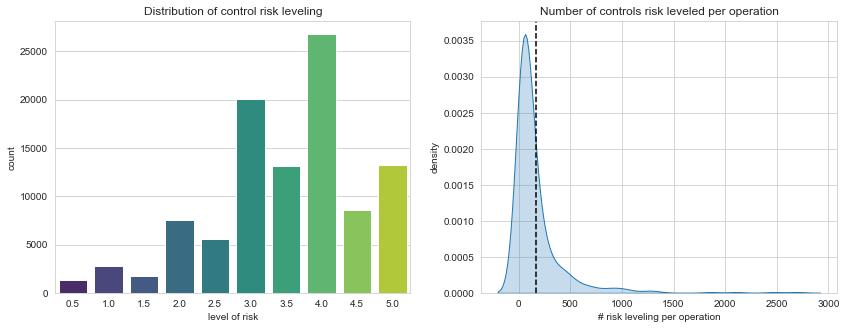

In [7]:
sns.set_style("whitegrid")
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
ax = sns.countplot(x="level of risk", data=level_of_risk, palette="viridis")
plt.title("Distribution of control risk leveling")

plt.subplot(1,2,2)
ax = sns.kdeplot(operation_freq['n_level_of_risk'], shade=True, legend=False)
plt.axvline(operation_freq['n_level_of_risk'].mean(), color="k", linestyle="--")
plt.xlabel("# risk leveling per operation")
plt.ylabel("density")
plt.title("Number of controls risk leveled per operation")
plt.show()

In [8]:
mean_risk_leveling = level_of_risk.groupby('controlId')[['level of risk']].mean()

lowest_risk_leveled = mean_risk_leveling['level of risk'].idxmin()
controls.loc[controls['controlId'] == lowest_risk_leveled]

,controlId,title,type
2689,3604.0,Grounding and Bonding,Fundamentally Stable Parking


In [9]:
highest_risk_leveled = mean_risk_leveling['level of risk'].idxmax()
controls.loc[controls['controlId'] == highest_risk_leveled]

,controlId,title,type
48,53.0,Wheel Management,NAP NOx abator low temperature protection


In [10]:
level_of_risk[level_of_risk['controlId']==highest_risk_leveled]

,operationId,controlId,level of risk,timestamp
13368,85,53,5.0,889468268
96115,603,53,5.0,963180003


In [11]:
control_stats = level_of_risk.groupby('controlId')[['level of risk']].agg(['count', 'mean'])
control_stats.columns = control_stats.columns.droplevel()

In [12]:
C = control_stats['count'].mean()
m = control_stats['mean'].mean()

def bayesian_avg(level_of_risk):
    bayesian_avg = (C*m+level_of_risk.sum())/(C+level_of_risk.count())
    return bayesian_avg

bayesian_avg_level_of_risk = level_of_risk.groupby('controlId')['level of risk'].agg(bayesian_avg).reset_index()
bayesian_avg_level_of_risk.columns = ['controlId', 'bayesian_avg']
control_stats = control_stats.merge(bayesian_avg_level_of_risk, on='controlId')

In [13]:
control_stats = control_stats.merge(controls[['controlId', 'title']])
control_stats.sort_values('bayesian_avg', ascending=False).head()

,controlId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392070,Fundamentally Stable Parking
659,858,192,4.289062,4.236457,Battery Isolation
2224,2959,218,4.272936,4.227052,Wheel Management
224,260,251,4.231076,4.192646,Seatbelts
46,50,204,4.237745,4.190567,Wheel Management


In [14]:
control_stats.sort_values('bayesian_avg', ascending=True).head()

,controlId,count,mean,bayesian_avg,title
1172,1556,19,1.605263,2.190377,Stand-by Person
2679,3593,19,1.657895,2.224426,Bearing Stand-off Distance
1372,1882,33,1.954545,2.267268,Battery Isolation
1144,1499,27,1.925926,2.296800,Stand-by Person
1988,2643,16,1.687500,2.306841,Secondary Restraints


In [15]:
from scipy.sparse import csr_matrix

def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        operation_mapper: dict that maps operation id's to operation indices
        operation_inv_mapper: dict that maps operation indices to operation id's
        control_mapper: dict that maps control id's to control indices
        control_inv_mapper: dict that maps control indices to control id's
    """
    N = df['operationId'].nunique()
    M = df['controlId'].nunique()

    operation_mapper = dict(zip(np.unique(df["operationId"]), list(range(N))))
    control_mapper = dict(zip(np.unique(df["controlId"]), list(range(M))))
    
    operation_inv_mapper = dict(zip(list(range(N)), np.unique(df["operationId"])))
    control_inv_mapper = dict(zip(list(range(M)), np.unique(df["controlId"])))
    
    operation_index = [operation_mapper[i] for i in df['operationId']]
    control_index = [control_mapper[i] for i in df['controlId']]

    X = csr_matrix((df["level of risk"], (control_index, operation_index)), shape=(M, N))
    
    return X, operation_mapper, control_mapper, operation_inv_mapper, control_inv_mapper

In [16]:
X, operation_mapper, control_mapper, operation_inv_mapper, control_inv_mapper = create_X(level_of_risk)

In [17]:
sparsity = X.count_nonzero()/(X.shape[0]*X.shape[1])

print(f"Matrix sparsity: {round(sparsity*100,2)}%")

Matrix sparsity: 1.7%


In [18]:
from scipy.sparse import save_npz

save_npz('operation_control_matrix.npz', X)

In [19]:
from numpy import load

data = load('operation_control_matrix.npz')
lst = data.files
for item in lst:
    print(item)
    print(data[item])

indices
[  0   4   6 ... 183 183 330]
indptr
[     0    215    325 ... 100834 100835 100836]
format
b'csr'
shape
[9724  610]
data
[4.  4.  4.5 ... 3.5 3.5 4. ]


In [20]:
from sklearn.neighbors import NearestNeighbors

def find_similar_controls(movie_id, X, k, metric='cosine', show_distance=False):
    """
    Finds k-nearest neighbours for a given control id.
    
    Args:
        control_id: id of the safe control
        X: operation-control utility matrix
        k: number of similar control to retrieve
        metric: distance metric for kNN calculations
    
    Returns:
        list of k similar control ID's
    """
    neighbour_ids = []
    
    control_ind = control_mapper[control_id]
    control_vec = X[control_ind]
    k+=1
    kNN = NearestNeighbors(n_neighbors=k, algorithm="brute", metric=metric)
    kNN.fit(X)
    if isinstance(control_vec, (np.ndarray)):
        control_vec = control_vec.reshape(1,-1)
    neighbour = kNN.kneighbors(control_vec, return_distance=show_distance)
    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(control_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [21]:
control_titles = dict(zip(controls['controlId'], controls['title']))

control_id = 1

similar_ids = find_similar_controls(control_id, X, k=10)
control_title = control_titles[control_id]

print(f"Because the opration done by {control_title} regarding the level of risk (and past incident similarity) as a safe control recommend:")
for i in similar_ids:
    print(control_titles[i])

Because the opration done by Wheel Management regarding the level of risk (and past incident similarity) as a safe control recommend:
Load Restraint System
Segregation of people and mobile equipment
Fall Equipment
Seatbelts
Fundamentally Stable Parking
Fundamentally Stable Parking
Physical Isolation of Stored Energy
Protected Work Area
Blast Area Access Control
Underground - Supported Ground


In [22]:
control_titles = dict(zip(controls['controlId'], controls['title']))

control_id = 1
similar_ids = find_similar_controls(control_id, X, k=10, metric="euclidean")

control_title = control_titles[control_id]
print(f"Because the opration done by {control_title} regarding the level of risk (and past incident similarity) as a safe control recommend::")
for i in similar_ids:
    print(control_titles[i])

Because the opration done by Wheel Management regarding the level of risk (and past incident similarity) as a safe control recommend::
Load Restraint System
Protected Work Area
Fall Equipment
Equipment conductive / dissipative
Protected Work Area
Thermofuse
Wheel Management
Blast Area Access Control
Fundamentally Stable Parking
Post Blast Inspection
